# Movie Sentiment Analysis : A Multinomial Naïve Bayes-Based Approach for Assessing User and Critic Opinions

## *Abstract*

*The growing volume of user-generated content, particularly in the form of movie reviews, presents both challenges and opportunities for researchers and practitioners in the movie industry. Sentiment analysis (SA) has emerged as a vital tool to automatically process and interpret this vast data repository, offering valuable insights into viewer preferences and opinions. This paper presents a comprehensive review of the techniques and applications of movie sentiment analysis, highlighting the role of natural language processing and machine learning algorithms in extracting sentiment from text data. In this project, I involve a comprehensive study of relevant NLP techniques, including data pre-processing, feature extraction, and model selection. The chosen Multinomial Na¨ıve Bayes algorithm will be trained on a data set of user critic reviews, with model performance evaluated based on multiple evaluation metrics. Results demonstrate a high classification accuracy of 86.3%, which indicates the effectiveness of the proposed solution. This confirms the potential of incorporating the designed approach into modern text-based sentiment analysis tools.*

## Import Libaries

In [1]:
import numpy as np # library for linear algebra and math utils
import pandas as pd # dataframe library
import matplotlib.pyplot as plt # plotting library
import seaborn as sns # data visualization


# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB # classifier 
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from sklearn.feature_extraction.text import TfidfVectorizer

# text preprocessing modules
import nltk
from string import punctuation 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re

# dependencies
for dependency in (
    "brown",
    "names",
    "wordnet",
    "stopwords",
    "punkt",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
import warnings
warnings.filterwarnings("ignore")

# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to /Users/kheey/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to /Users/kheey/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kheey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kheey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kheey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kheey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/kheey/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


## Loading the Data

For this project, I will be using a data set containing 50k movie reviews from IMDb. The data have already been splitted into 25k reviews for training purposes while the other 25k is intended for testing the classifier. In addition, both sets contain 12.5k positive and negative reviews.

In [3]:
# load data
data = pd.read_csv("../data/labeledTrainData.tsv", sep='\t')

Show sample of the dataset.

In [4]:
# show the first five rows of our labeled dataset
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


Our dataset has 3 columns.

- Id — This is the id of the review
- Sentiment — either positive(1) or negative(0)
- Review — comment about the movie


Check the shape of the dataset.

In [5]:
# check the shape of the data
data.shape

(25000, 3)

The dataset has 25,000 reviews.

We need to check if the dataset has any missing values.

In [6]:
# check missing values in data
data.isnull().sum()

id           0
sentiment    0
review       0
dtype: int64

The output shows that our dataset does not have any missing values.

> How to Evaluate Class Distribution ?

We can use the value_counts() method from the pandas package to evaluate the class distribution from our dataset.

In [6]:
# evaluate news sentiment distribution
data.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [7]:
def plot_sentiment_distribution(data, column_name="sentiment") -> None:
    """
    Plots a bar chart representing the sentiment distribution of movie reviews.

    Parameters:
    data (pd.DataFrame): A DataFrame containing the movie reviews data.
    column_name (str, optional): The name of the column containing sentiment
                                 values. Defaults to 'sentiment'.

    Returns:
    None
    """
    
    # set the style for the seaborn plot
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="ticks", rc=custom_params)

    # calculate sentiment counts
    sentiment_counts = data[column_name].value_counts()
    colour_palette = ['red', 'green']

    # create a bar plot for sentiment distribution
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, width=0.5, palette=colour_palette, alpha=0.65)

    # customize gridlines
    ax.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.1)

    # set labels and title
    ax.set_title('Sentiment Distribution', fontsize=16)
    ax.set_xticklabels(['Negative (0)', 'Positive (1)'], fontsize=12)

    # display values on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.show()
    
    # reset the default style for seaborn
    sns.reset_defaults()


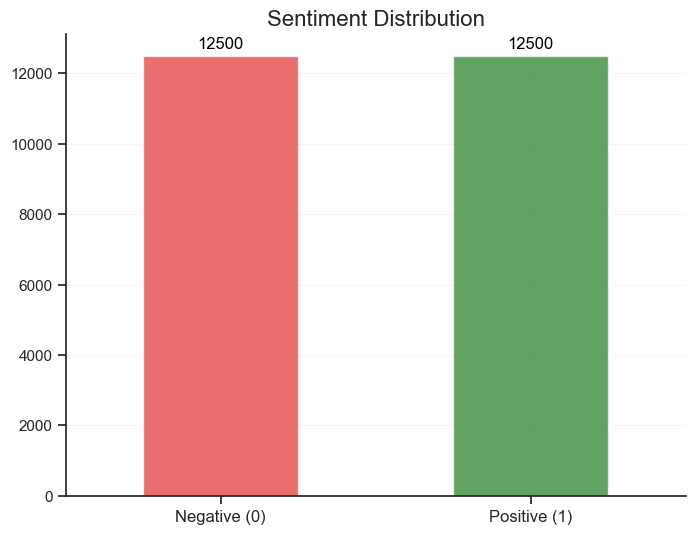

In [8]:
# Plot the sentiment distribution
plot_sentiment_distribution(data)

In this dataset, we have an equal number of positive and negative reviews.

It’s also interesting to see the distribution of the length of movie reviews (word count) split according to sentiment.

In [9]:
def plot_review_length_distribution(data, column_name="review", sentiment_column="sentiment") -> None:
    """
    Plots a histogram representing the distribution of the length of movie reviews
    split according to sentiment.

    Parameters:
    data (pd.DataFrame): A DataFrame containing the movie reviews data.
    column_name (str, optional): The name of the column containing the review text.
                                 Defaults to 'review'.
    sentiment_column (str, optional): The name of the column containing the sentiment
                                       values. Defaults to 'sentiment'.

    Returns:
    None
    """
    
    # Filter data by sentiment
    pos_reviews = data[data[sentiment_column] == 1][column_name]
    neg_reviews = data[data[sentiment_column] == 0][column_name]

    # Calculate review lengths
    pos_lengths = pos_reviews.apply(lambda x: len(x.split()))
    neg_lengths = neg_reviews.apply(lambda x: len(x.split()))

    # Calculate average and standard deviation of review lengths
    avg_length = np.mean(data[column_name].apply(lambda x: len(x.split())))
    std_length = np.std(data[column_name].apply(lambda x: len(x.split())))

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(neg_lengths, color='red', alpha=0.5, label='Negative')
    sns.histplot(pos_lengths, color='green', alpha=0.5, label='Positive')
    plt.legend()
    plt.xlabel('Review Length (Word Count)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Review Length by Sentiment', fontsize=16)

    # Add lines for mean and standard deviation
    plt.axvline(x=avg_length, color='black', linestyle='--', label='Mean')
    plt.axvline(x=avg_length + std_length, color='gray', linestyle='--', label='Standard Deviation')
    plt.axvline(x=avg_length - std_length, color='gray', linestyle='--')

    plt.legend()
    plt.show()

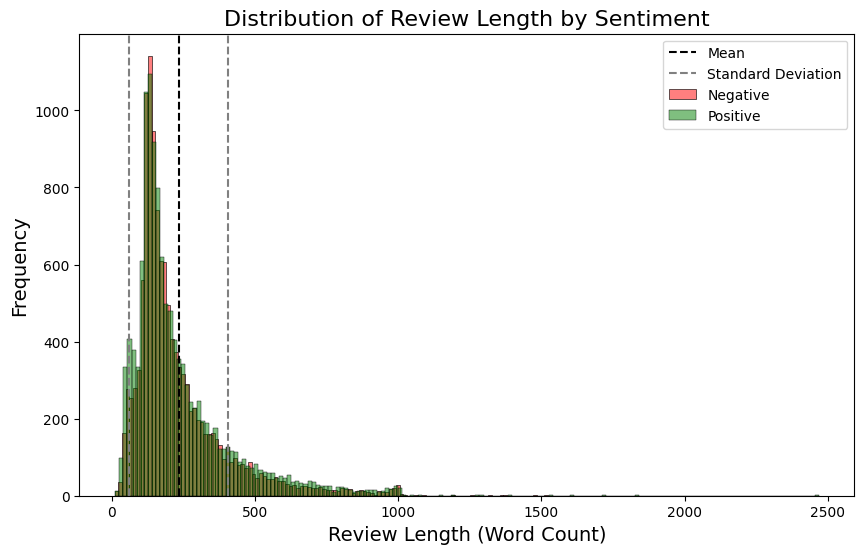

In [10]:
plot_review_length_distribution(data)

The reviews are classified into positive and negative in reference to the IMDb rating system. It allows viewers to rate on a scale from 1 to 10, and according to the data set creator anything less than 4 stars is labeled negative, and above 7 stars is marked as positive. Reviews with ratings out of the above ranges are not included. There are at most 30 reviews for each movie. The average number of words per review is 233.79 with a standard deviation of 173.73 words as shown in the Figure above.

The spread is similar in shape for both types of reviews however negative reviews are on average a tad shorter.

## Preprocessing the Data

For any machine learning project, once you’ve gathered the data, the first step is to process it to make useful inputs to your model. Data preprocessing is a crucial task in the data mining process. It refers to cleaning up the data from useless information that will not help in the training process and might cause confusion during the classification process. For the IMDb data set, several data preprocessing steps are utilized.

***Text Tokenization:*** Tokenization is the process of dissecting a text segment into smaller units, referred to as tokens. These tokens can consist of words, word fragments, or punctuation marks, allowing for more effective natural language processing and analysis.

***Word Filtering:*** To remove noise from the data, we will first eliminate words that don’t provide much information about the content, such as common words like ’I, you, are, is, etc.’ that don’t offer sufficient insight into sentiment. Then, we will remove hyperlinks, hashtags, and punctuation to ensure words with or without punctuation are treated as the same word. For example, ”happy”, ”happy?”, ”happy!”, ”happy,” and ”happy.” should all be considered as the same word.

***Stemming:*** Stemming entails eliminating prefixes and suffixes from a word to obtain its base or root form. The Porter stemming algorithm, a rule-based method developed by Martin Porter, is commonly employed for this purpose. In this algorithm, a consonant is defined as any letter excluding vowels. The calculation of conditions in the algorithm is demonstrated in Form 1, where optional content is represented by square brackets, and (V C) m indicates a sequence of a Vowel (V ) followed by a Consonant (C) repeated m times.

<div style="text-align:center">

$$\left[ C \right] (VC)^m \left[ V \right]$$

</div>

This algorithm adheres to a set of rules that consist of patterns along with their associated conditions.

<div style="text-align:center">

$$S1 \longrightarrow S2$$

</div>

If a pattern is found to match and the word concludes with the S1 suffix, the suffix is converted from S1 to S2, and the algorithm starts anew from the list’s beginning to identify the subsequent matching pattern. Should no pattern match, the algorithm then outputs the result.

In [11]:
stop_words = stopwords.words("english")


def process_review(text, remove_stop_words=True, lemmatize_words=True, stemming_words=True) -> str:
    """
    Clean and preprocess text data by removing unwanted characters, stop words, and lemmatizing words.

    This function takes a raw text input and processes it by removing non-alphanumeric characters,
    punctuation, numbers, and optionally, stop words, lemmatizing and stemming. The output is a cleaned
    and preprocessed version of the input text.

    Parameters:
    text (str): The raw text input to be processed.
    remove_stop_words (bool, optional): If True, removes stop words from the input text. Defaults to True.
    lemmatize_words (bool, optional): If True, lemmatizes words in the input text. Defaults to True.
    stemming_words (bool, optional): If True, lemmatizes words in the input text. Defaults to True.

    Returns:
    str: The cleaned and preprocessed version of the input text.
    """

    # Remove non-alphanumeric characters, punctuation, and numbers
    text = re.sub(r'\W+', ' ', text.lower())

    # Remove hyperlinks
    text = re.sub(r'http\S+|www\S+', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize words
    if lemmatize_words:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stem words
    if stemming_words:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)


Let's test our function on a sample review.

In [12]:
custom_review = "@Thor Thank you, Taika! We Laughed for the first time in a week!:) Great, fun, full hearted, just go watch it and have fun!!! #good #film https://chapagain.com"

# print cleaned tweet
print(process_review(custom_review))

thor thank taika laugh first time week great fun full heart go watch fun good film chapagain com


Now we can clean our dataset by using the process_review() function.

In [13]:
#clean the review
data["cleaned_review"] = data["review"].apply(process_review)

Then we split data into feature and target variables.

In [14]:
#split features and target from  data 
X = data["cleaned_review"]
y = data.sentiment.values

Our feature for training is the cleaned_review variable and the target is the sentiment variable.

We then split our dataset into train and test data. The test size is 15% of the entire dataset.

In [15]:
# split data into train and validate
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    shuffle=True,
    stratify=y,
)

## Multinomial Naive Bayes algorithm

We will train the Multinomial Naive Bayes algorithm to classify if a review is positive or negative. This is one of the most common algorithms used for text classification.

But before training the model, we need to transform our cleaned reviews into numerical values so that the model can understand the data. In this case, we will use the TfidfVectorizer method from scikit-learn. TfidfVectorizer will help us to convert a collection of text documents to a matrix of TF-IDF features.

To apply this series of steps(pre-processing and training), we will use a Pipeline class from scikit-learn that sequentially applies a list of transforms and a final estimator.

In [16]:
# Create a classifier in pipeline
sentiment_classifier = Pipeline(steps=[
                               ('pre_processing',TfidfVectorizer(lowercase=False)),
                                 ('naive_bayes',MultinomialNB())
                                 ])

Then we train our classifier.

In [17]:
# train the sentiment classifier 
sentiment_classifier.fit(X_train,y_train)

Pipeline(steps=[('pre_processing', TfidfVectorizer(lowercase=False)),
                ('naive_bayes', MultinomialNB())])

## Evaluating the model

We then create a prediction from the validation set.

In [18]:
# test model performance on valid data 
y_preds = sentiment_classifier.predict(X_valid)

The model’s performance will be evaluated by using accuracy_score, classification_report and confusion matrix.

In [19]:
accuracy = accuracy_score(y_valid, y_preds)
cm = confusion_matrix(y_valid, y_preds)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8632


In [20]:
report = classification_report(y_valid, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1875
           1       0.87      0.85      0.86      1875

    accuracy                           0.86      3750
   macro avg       0.86      0.86      0.86      3750
weighted avg       0.86      0.86      0.86      3750



In [21]:
def display_confusion_matrix(y_true, y_pred, labels=None) -> None:
    
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    cmap = plt.cm.Blues
    disp = disp.plot(cmap=cmap, xticks_rotation='vertical', values_format='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Sentiment Classification Model')
    plt.tight_layout()
    plt.show()

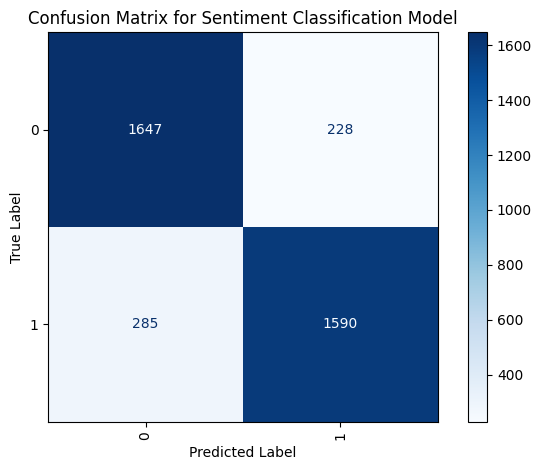

In [22]:
display_confusion_matrix(y_valid, y_preds, labels=sentiment_classifier.classes_)

## Saving Model Pipeline

The model pipeline will be saved in the model’s folder by using the joblib python package.

In [68]:
#save model 
import joblib 
joblib.dump(sentiment_classifier, 'model/sentiment_model_pipeline.pkl')

['model/sentiment_model_pipeline.pkl']